# Robust estimation with optimization functionals with Chirho

## Setup

Here, we install the necessary Pytorch, Pyro, and ChiRho dependencies for this example.

In [1]:
from typing import Callable, Optional, Tuple

import functools
import torch
import math
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchopt

import pyro
import pyro.distributions as dist
from pyro.infer import Predictive
import pyro.contrib.gp as gp

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from chirho.robust.internals.utils import ParamDict
from chirho.robust.handlers.estimators import one_step_corrected_estimator, tmle
from chirho.robust.ops import influence_fn
from chirho.robust.handlers.predictive import PredictiveModel, PredictiveFunctional
from chirho.robust.internals.nmc import BatchedNMCLogMarginalLikelihood


pyro.settings.set(module_local_params=True)

sns.set_style("white")

NOTE: Redirects are currently not supported in Windows or MacOs.


## Causal Probabilistic Program

### Model Description
In this example, we will focus on a cannonical model `CausalGLM` consisting of three types of variables: binary treatment (`A`), confounders (`X`), and response (`Y`). For simplicitly, we assume that the response is generated from a generalized linear model with link function $g$. The model is described by the following generative process:

$$
\begin{align*}
X &\sim \text{Normal}(0, I_p) \\
A &\sim \text{Bernoulli}(\pi(X)) \\
\mu &= \beta_0 + \beta_1^T X + \tau A \\
Y &\sim \text{ExponentialFamily}(\text{mean} = g^{-1}(\mu))
\end{align*}
$$

where $p$ denotes the number of confounders, $\pi(X)$ is the probability of treatment conditional on confounders $X$, $\beta_0$ is the intercept, $\beta_1$ is the confounder effect, and $\tau$ is the treatment effect.

In [149]:
class CausalGLM(pyro.nn.PyroModule):
    def __init__(
        self,
        p: int,
        treatment_fn: Callable[..., dist.Distribution] = lambda mu: dist.Normal(mu, 1.0),
        link_fn: Callable[..., dist.Distribution] = lambda mu: dist.Normal(mu, 1.0),
        prior_scale: Optional[float] = None,
    ):
        super().__init__()
        self.p = p
        self.treatment_fn = treatment_fn
        self.link_fn = link_fn
        if prior_scale is None:
            self.prior_scale = 1 / math.sqrt(self.p)
        else:
            self.prior_scale = prior_scale

    def sample_outcome_weights(self):
        return pyro.sample(
            "outcome_weights",
            dist.Normal(0.0, self.prior_scale).expand((self.p,)).to_event(1),
        )

    def sample_intercept(self):
        return pyro.sample("intercept", dist.Normal(0.0, 1.0))

    def sample_propensity_weights(self):
        return pyro.sample(
            "propensity_weights",
            dist.Normal(0.0, self.prior_scale).expand((self.p,)).to_event(1),
        )

    def sample_treatment_weight(self):
        return pyro.sample("treatment_weight", dist.Normal(0.0, 1.0))

    def sample_covariate_loc_scale(self):
        return torch.zeros(self.p), torch.ones(self.p)

    def forward(self):
        intercept = self.sample_intercept()
        outcome_weights = self.sample_outcome_weights()
        propensity_weights = self.sample_propensity_weights()
        tau = self.sample_treatment_weight()
        x_loc, x_scale = self.sample_covariate_loc_scale()
        X = pyro.sample("X", dist.Normal(x_loc, x_scale).to_event(1))
        A = pyro.sample(
            "A",
            self.treatment_fn(
                torch.einsum("...i,...i->...", X, propensity_weights)
            ),
        )

        return pyro.sample(
            "Y",
            self.link_fn(
                torch.einsum("...i,...i->...", X, outcome_weights) + A * tau + intercept
            ),
        )

Next, we will condition on both treatment and confounders to estimate the causal effect of treatment on the outcome. We will use the following causal probabilistic program to do so:

In [150]:
class ConditionedCausalGLM(CausalGLM):
    def __init__(
        self,
        X: torch.Tensor,
        A: torch.Tensor,
        Y: torch.Tensor,
        treatment_fn: Callable[..., dist.Distribution] = lambda mu: dist.Normal(mu, 1.0),
        link_fn: Callable[..., dist.Distribution] = lambda mu: dist.Normal(mu, 1.0),
        prior_scale: Optional[float] = None,
    ):
        p = X.shape[1]
        super().__init__(p, treatment_fn, link_fn, prior_scale)
        self.X = X
        self.A = A
        self.Y = Y

    def forward(self):
        intercept = self.sample_intercept()
        outcome_weights = self.sample_outcome_weights()
        propensity_weights = self.sample_propensity_weights()
        tau = self.sample_treatment_weight()
        x_loc, x_scale = self.sample_covariate_loc_scale()
        with pyro.plate("__train__", size=self.X.shape[0], dim=-1):
            X = pyro.sample("X", dist.Normal(x_loc, x_scale).to_event(1), obs=self.X)
            A = pyro.sample(
                "A",
                self.treatment_fn(
                    torch.einsum("ni,i->n", self.X, propensity_weights)
                ),
                obs=self.A,
            )
            pyro.sample(
                "Y",
                self.link_fn(
                    torch.einsum("ni,i->n", X, outcome_weights)
                    + A * tau
                    + intercept
                ),
                obs=self.Y,
            )

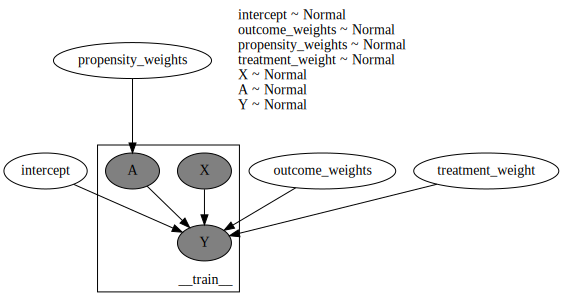

In [151]:
# Visualize the model
pyro.render_model(
    ConditionedCausalGLM(torch.zeros(1, 1), torch.zeros(1), torch.zeros(1)),
    render_params=True, 
    render_distributions=True
)

### Generating data

For evaluation, we generate `N_datasets` datasets, each with `N` samples. We compare vanilla estimates of the target functional with the double robust estimates of the target functional across the `N_sims` datasets. We use a similar data generating process as in Kennedy (2022).

In [152]:
class GroundTruthModel(CausalGLM):
    def __init__(
        self,
        p: int,
        alpha: int,
        beta: int,
        treatment_fn: Callable[..., dist.Distribution] = lambda mu: dist.Normal(mu, 1.0),
        link_fn: Callable[..., dist.Distribution] = lambda mu: dist.Normal(mu, 1.0),
        treatment_weight: float = 1.0,
    ):
        super().__init__(p, treatment_fn, link_fn)
        self.alpha = alpha  # sparsity of propensity weights
        self.beta = beta  # sparsity of outcome weights
        self.treatment_weight = treatment_weight

    def sample_outcome_weights(self):
        outcome_weights = 1 / math.sqrt(self.beta) * torch.ones(self.p)
        outcome_weights[self.beta :] = 0.0
        return outcome_weights

    def sample_propensity_weights(self):
        propensity_weights = 1 / math.sqrt(self.alpha) * torch.ones(self.p)
        propensity_weights[self.alpha :] = 0.0
        return propensity_weights

    def sample_treatment_weight(self):
        return torch.tensor(self.treatment_weight)

    def sample_intercept(self):
        return torch.tensor(0.0)

In [153]:
# Data configuration
p = 2
alpha = 50
beta = 50
N_train = 500
N_test = 500

true_model = GroundTruthModel(p, alpha, beta)

def generate_data(N_train, N_test):
    # Generate data
    D_train = Predictive(
        true_model, num_samples=N_train, return_sites=["X", "A", "Y"]
    )()
    D_test = Predictive(
        true_model, num_samples=N_test, return_sites=["X", "A", "Y"]
    )()
    return D_train, D_test

### Fit parameters via maximum likelihood

In [193]:
def MLE(D_train, n_steps=2000):
    # Fit model using maximum likelihood
    conditioned_model = ConditionedCausalGLM(
        X=D_train["X"], A=D_train["A"], Y=D_train["Y"]
    )
    
    guide_train = pyro.infer.autoguide.AutoDelta(conditioned_model)
    elbo = pyro.infer.Trace_ELBO()(conditioned_model, guide_train)

    # initialize parameters
    elbo()
    adam = torch.optim.Adam(elbo.parameters(), lr=0.03)

    # Do gradient steps
    for _ in range(n_steps):
        adam.zero_grad()
        loss = elbo()
        loss.backward()
        adam.step()

    theta_hat = {
        k: v.clone().detach().requires_grad_(True) for k, v in guide_train().items()
    }
    return theta_hat

## Causal Query: Average treatment effect (ATE)

The average treatment effect summarizes, on average, how much the treatment changes the response, $ATE = \mathbb{E}[Y|do(A=1)] - \mathbb{E}[Y|do(A=0)]$. The `do` notation indicates that the expectations are taken according to *intervened* versions of the model, with $A$ set to a particular value. Note from our [tutorial](tutorial_i.ipynb) that this is different from conditioning on $A$ in the original `causal_model`, which assumes $X$ and $T$ are dependent.


To implement this query in ChiRho, we define the `ATEFunctional` class which take in a `model` and `guide` and returns the average treatment effect by simulating from the posterior predictive distribution of the model and guide.

### Defining the target functional

In [194]:
class MaximizeATEFunctional(torch.nn.Module):
    def __init__(self, model: Callable, *, 
                 num_monte_carlo: int = 100,
                 optimizer = torchopt.adam,
                 learning_rate = 1.0,
                 n_grad_steps:int = 100,
                 ):
        super().__init__()
        self.model = model
        self.num_monte_carlo = num_monte_carlo
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.n_grad_steps = n_grad_steps
    
    def dose_response(self, treatment_assignment: torch.Tensor, *args, **kwargs):
        with pyro.plate("monte_carlo_functional", size=self.num_monte_carlo, dim=-2):
            with do(actions=dict(A=(treatment_assignment))):
                Ys = self.model(*args, **kwargs)
        return pyro.deterministic("dose_response", Ys.mean(dim=-1, keepdim=True).squeeze())

        # Y0 = gather(Ys, IndexSet(A={1}), event_dim=0)
        #     Y1 = gather(Ys, IndexSet(A={2}), event_dim=0)
        # ate = (Y1 - Y0).mean(dim=-2, keepdim=True).mean(dim=-1, keepdim=True).squeeze()
        # return pyro.deterministic("ATE", ate)
    
    def loss(self, treatment_assignment: torch.Tensor, *args, **kwargs):

        # Penalize squared treatment assignment magnitude, while maximizing dose response.

        return treatment_assignment**2 - self.dose_response(treatment_assignment, *args, **kwargs)


    def forward(self, *args, **kwargs):
        
        treatment_assignment = (torch.tensor(1.0, requires_grad=True),)

        optimizer = self.optimizer(self.learning_rate)
        opt_state = optimizer.init(treatment_assignment)
        
        for _ in range(self.n_grad_steps):
            loss = self.loss(treatment_assignment[0])

            grads = torch.autograd.grad(loss, treatment_assignment, create_graph=True)
            updates, opt_state = optimizer.update(grads, opt_state, inplace=False)

            treatment_assignment = torchopt.apply_updates(treatment_assignment, updates, inplace=False)

        return pyro.deterministic("optimal_treatment_assignment", treatment_assignment[0])

### Computing automated doubly robust estimators via Monte Carlo

While the doubly robust correction term is known in closed-form for the average treatment effect functional, our `one_step_correction` and `tmle` function in `ChiRho` works for a wide class of other functionals. We focus on the average treatment effect functional here so that we have a ground truth to compare `one_step_correction` against the plug in estimates.

In [195]:
# Helper class to create a trivial guide that returns the maximum likelihood estimate
class MLEGuide(torch.nn.Module):
    def __init__(self, mle_est: ParamDict):
        super().__init__()
        self.names = list(mle_est.keys())
        for name, value in mle_est.items():
            setattr(self, name + "_param", torch.nn.Parameter(value))

    def forward(self, *args, **kwargs):
        for name in self.names:
            value = getattr(self, name + "_param")
            pyro.sample(
                name, pyro.distributions.Delta(value, event_dim=len(value.shape))
            )

In [199]:
functional = functools.partial(MaximizeATEFunctional, 
                               num_monte_carlo=10000, 
                               optimizer=torchopt.adam,
                               learning_rate=1.0,
                               n_grad_steps=1)

D_train, D_test = generate_data(N_train, N_test)

theta_hat = MLE(D_train, n_steps=2)

theta_hat = {
    k: v.clone().detach().requires_grad_(True) for k, v in theta_hat.items()
}
mle_guide = MLEGuide(theta_hat)
model = PredictiveModel(CausalGLM(p), mle_guide)

eif_fn = influence_fn(functional, D_test, num_samples_outer=100, pointwise_influence=False)

correction_estimator = eif_fn(model)
correction = correction_estimator()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [160]:
import json
import os

# Compute doubly robust ATE estimates using both the automated and closed form expressions
N_datasets = 1


# Estimators to compare
estimators = {"one_step": one_step_corrected_estimator}
estimator_kwargs = {
    "one_step": {}
}

# Influence functions
influences = {"monte_carlo_eif": influence_fn}

# Cache the results
RESULTS_PATH = "../results/opt_causal_glm.json"

if os.path.exists(RESULTS_PATH):
    with open(RESULTS_PATH, "r") as f:
        estimates = json.load(f)
    i_start = len(estimates["plug-in-mle-from-model"]) 
else:
    estimates = {f"{influence}-{estimator}": [] for influence in influences.keys() for estimator in estimators.keys()}
    estimates["plug-in-mle-from-model"] = []
    i_start = 0

# ATE functional of interest
functional = functools.partial(MaximizeATEFunctional, num_monte_carlo=10000)

for i in range(i_start, N_datasets):
    pyro.set_rng_seed(i) # for reproducibility
    print("Dataset", i)
    D_train, D_test = generate_data(N_train, N_test)
    theta_hat = MLE(D_train, D_test)

    theta_hat = {
        k: v.clone().detach().requires_grad_(True) for k, v in theta_hat.items()
    }
    mle_guide = MLEGuide(theta_hat)
    model = PredictiveModel(CausalGLM(p), mle_guide)
    
    print("plug-in-mle-from-model", i)
    estimates["plug-in-mle-from-model"].append(functional(model)().detach().item())

    for estimator_str, estimator in estimators.items():
        for influence_str, influence in influences.items():
            print(estimator_str, influence_str, i)
            estimate = estimator(
                functional, 
                D_test,
                num_samples_outer=max(10000, 100 * p), 
                num_samples_inner=1,
                influence_estimator=influence,
                **estimator_kwargs[estimator_str]
            )(PredictiveModel(CausalGLM(p), mle_guide))()

            estimates[f"{influence_str}-{estimator_str}"].append(estimate.detach().item())

    with open(RESULTS_PATH, "w") as f:
        json.dump(estimates, f, indent=4)

Dataset 0
plug-in-mle-from-model 0
one_step monte_carlo_eif 0


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [12]:
# The true treatment effect is 0, so a mean estimate closer to zero is better
results = pd.DataFrame(estimates)
results.describe().round(2)

,analytic_eif-tmle,analytic_eif-one_step,analytic_eif-double_ml,monte_carlo_eif-tmle,monte_carlo_eif-one_step,monte_carlo_eif-double_ml,plug-in-mle-from-model,plug-in-mle-from-test
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
mean,0.33,0.22,0.73,0.33,0.22,0.72,0.34,0.84
std,0.11,0.11,0.13,0.11,0.11,0.13,0.11,0.13
min,0.14,-0.03,0.46,0.13,-0.08,0.42,0.11,0.56
25%,0.24,0.15,0.65,0.27,0.16,0.65,0.26,0.76
50%,0.33,0.23,0.73,0.33,0.22,0.73,0.33,0.83
75%,0.39,0.29,0.81,0.39,0.29,0.80,0.40,0.92
max,0.65,0.61,1.09,0.65,0.57,1.05,0.68,1.15


/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

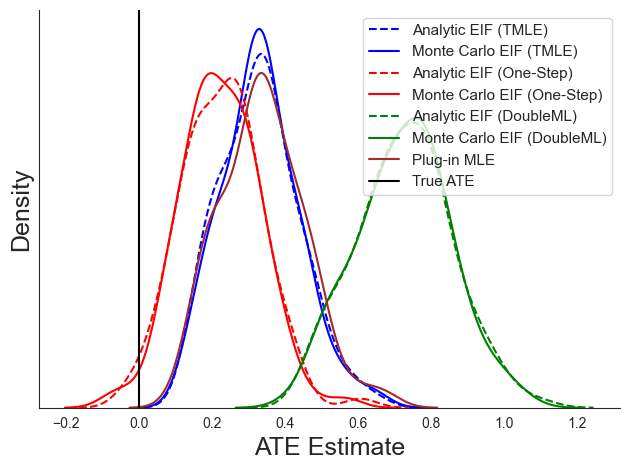

In [13]:
# Visualize the results
fig, ax = plt.subplots()

# TMLE
sns.kdeplot(
    estimates['analytic_eif-tmle'], 
    label="Analytic EIF (TMLE)",
    ax=ax,
    color='blue',
    linestyle='--'
)

sns.kdeplot(
    estimates['monte_carlo_eif-tmle'], 
    label="Monte Carlo EIF (TMLE)",
    ax=ax,
    color='blue'
)

# One-step
sns.kdeplot(
    estimates['analytic_eif-one_step'], 
    label="Analytic EIF (One-Step)",
    ax=ax,
    color='red',
    linestyle='--'
)

sns.kdeplot(
    estimates['monte_carlo_eif-one_step'], 
    label="Monte Carlo EIF (One-Step)",
    ax=ax,
    color='red'
)

# DoubleML
sns.kdeplot(
    estimates['analytic_eif-double_ml'], 
    label="Analytic EIF (DoubleML)",
    ax=ax,
    color='green',
    linestyle='--'
)

sns.kdeplot(
    estimates['monte_carlo_eif-double_ml'], 
    label="Monte Carlo EIF (DoubleML)",
    ax=ax,
    color='green'
)

# Plug-in MLE
sns.kdeplot(
    estimates['plug-in-mle-from-model'], 
    label="Plug-in MLE",
    ax=ax,
    color='brown'
)

ax.axvline(0, color="black", label="True ATE", linestyle="solid")
ax.set_yticks([])
sns.despine()
ax.set_xlabel("ATE Estimate", fontsize=18)
ax.set_ylabel("Density", fontsize=18)

ax.legend(loc="upper right", fontsize=11)

plt.tight_layout()

plt.savefig('figures/causal_glm_performance_vs_estimator.png')

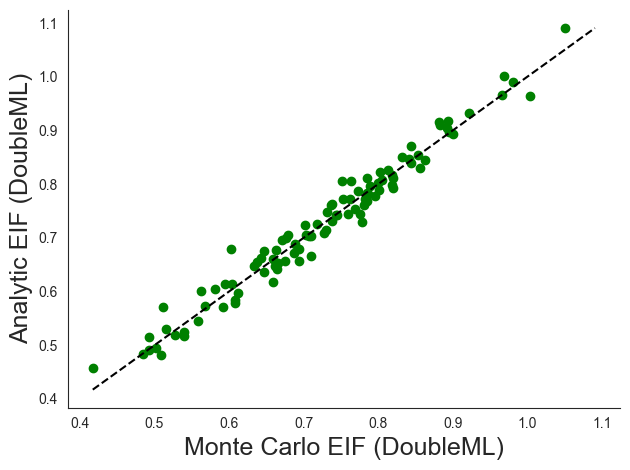

In [14]:
# Double ML
plt.scatter(
    estimates['monte_carlo_eif-double_ml'],
    estimates['analytic_eif-double_ml'],
    color='green',
)

# Plot y=x line for min and max values
min_val = min(
    min(estimates['monte_carlo_eif-double_ml']),
    min(estimates['analytic_eif-double_ml'])
)
max_val = max(
    max(estimates['monte_carlo_eif-double_ml']),
    max(estimates['analytic_eif-double_ml'])
)
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')
plt.xlabel("Monte Carlo EIF (DoubleML)", fontsize=18)
plt.ylabel("Analytic EIF (DoubleML)", fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('./figures/double_convergence_causal_glm.png')

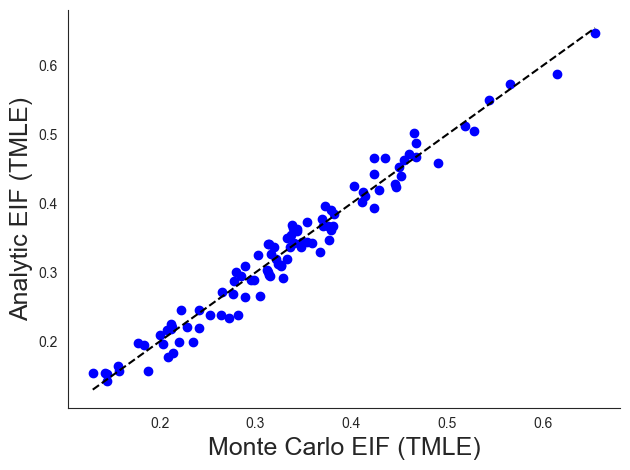

In [15]:
# TMLE
plt.scatter(
    estimates['monte_carlo_eif-tmle'],
    estimates['analytic_eif-tmle'],
    color='blue',
)

# Plot y=x line for min and max values
min_val = min(
    min(estimates['monte_carlo_eif-tmle']),
    min(estimates['analytic_eif-tmle'])
)
max_val = max(
    max(estimates['monte_carlo_eif-tmle']),
    max(estimates['analytic_eif-tmle'])
)
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')
plt.xlabel("Monte Carlo EIF (TMLE)", fontsize=18)
plt.ylabel("Analytic EIF (TMLE)", fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('./figures/tmle_convergence_causal_glm.png')

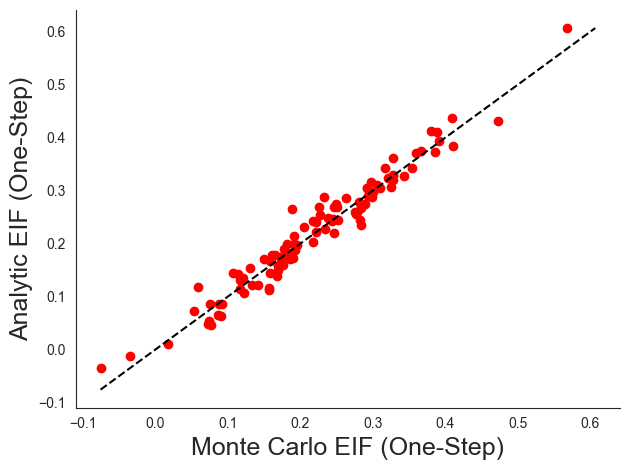

In [16]:
# One-step
plt.scatter(
    estimates['monte_carlo_eif-one_step'],
    estimates['analytic_eif-one_step'],
    color='red',
)

# Plot y=x line for min and max values
min_val = min(
    min(estimates['monte_carlo_eif-one_step']),
    min(estimates['analytic_eif-one_step'])
)
max_val = max(
    max(estimates['monte_carlo_eif-one_step']),
    max(estimates['analytic_eif-one_step'])
)
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')
plt.xlabel("Monte Carlo EIF (One-Step)", fontsize=18)
plt.ylabel("Analytic EIF (One-Step)", fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('./figures/one_step_convergence_causal_glm.png')

## References

Kennedy, Edward. "Towards optimal doubly robust estimation of heterogeneous causal effects", 2022. https://arxiv.org/abs/2004.14497.